In [1]:
import datetime
import pandas as pd
from xgboost import XGBRegressor
import hopsworks
import json
from functions import utils
import os

In [2]:
from dotenv import load_dotenv
load_dotenv()
HOPSWORKS_API_KEY = os.getenv("HOPSWORKS_API_KEY")
os.environ["HOPSWORKS_API_KEY"] = HOPSWORKS_API_KEY

In [3]:
today = datetime.datetime.now() - datetime.timedelta(0)
tomorrow = today + datetime.timedelta(days = 1)
yesterday = today - datetime.timedelta(days = 1)
today

datetime.datetime(2025, 1, 8, 9, 58, 43, 875223)

In [4]:
project = hopsworks.login()
fs = project.get_feature_store() 

2025-01-08 09:58:43,891 INFO: Initializing external client
2025-01-08 09:58:43,892 INFO: Base URL: https://c.app.hopsworks.ai:443
2025-01-08 09:58:45,476 INFO: Python Engine initialized.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/1207494


In [5]:
CITY = "dublin"
STATION_1 = "MOUNTJOY SQUARE WEST"
STATION_2 = "HEUSTON BRIDGE (NORTH)"

STATION_1 = STATION_1.replace(" ", "_")
STATION_2 = STATION_2.replace(" ", "_")

In [6]:
feature_view = fs.get_feature_view(
    name='bike_weather_fw',
    version=1,
)

In [7]:
mr = project.get_model_registry()

retrieved_model_1 = mr.get_model(
    name="bike_availability_xgboost_model_1",
    version=1,
)

retrieved_model_2 = mr.get_model(
    name="bike_availability_xgboost_model_2",
    version=1,
)

# Download the saved model artifacts to a local directory
saved_model_dir = retrieved_model_1.download()
saved_model_dir = retrieved_model_2.download()

In [8]:
retrieved_xgboost_model_1 = XGBRegressor()

retrieved_xgboost_model_1.load_model(saved_model_dir + "/model_1.json")

# Displaying the retrieved XGBoost regressor model
# retrieved_xgboost_model_1

In [9]:
retrieved_xgboost_model_2 = XGBRegressor()

retrieved_xgboost_model_2.load_model(saved_model_dir + "/model_2.json")

# Displaying the retrieved XGBoost regressor model
#retrieved_xgboost_model_2

In [10]:
weather_fg = fs.get_feature_group(
    name='weather_data',
    version=1,
)
batch_data = weather_fg.filter(weather_fg.datetime >= today).read()
batch_data["month"] = batch_data["datetime"].dt.month
batch_data["weekday"] = batch_data["datetime"].dt.weekday  # 0=Monday, 6=Sunday
batch_data["hour"] = batch_data["datetime"].dt.hour
batch_data

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (0.65s) 


,datetime,temperature_2m,apparent_temperature,rain,snowfall,wind_speed_10m,daylight_duration,rain_sum,city,month,weekday,hour
0,2025-01-16 22:00:00+00:00,5.05,2.094080,0.0,0.0,10.948973,29183.220703,0.0,dublin,1,3,22
1,2025-01-14 08:00:00+00:00,10.45,9.437586,0.0,0.0,6.439876,28859.789062,0.0,dublin,1,1,8
2,2025-01-15 15:00:00+00:00,6.70,5.603458,0.0,0.0,1.297998,29019.097656,0.0,dublin,1,2,15
3,2025-01-12 03:00:00+00:00,2.70,0.246478,0.0,0.0,5.014219,28556.771484,0.9,dublin,1,6,3
4,2025-01-12 01:00:00+00:00,3.50,1.108303,0.0,0.0,5.600286,28556.771484,0.9,dublin,1,6,1
...,...,...,...,...,...,...,...,...,...,...,...,...
200,2025-01-12 02:00:00+00:00,2.95,0.515792,0.0,0.0,5.191994,28556.771484,0.9,dublin,1,6,2
201,2025-01-12 21:00:00+00:00,11.45,7.875097,0.0,0.0,23.400000,28556.771484,0.9,dublin,1,6,21
202,2025-01-09 19:00:00+00:00,-2.25,-6.214783,0.0,0.0,9.531505,28145.916016,0.0,dublin,1,3,19
203,2025-01-16 13:00:00+00:00,6.70,5.074124,0.0,0.0,4.693825,29183.220703,0.0,dublin,1,3,13


## Creating predictions

In [11]:
batch_data['bikes_available_stn_1'] = retrieved_xgboost_model_1.predict(
    batch_data[['temperature_2m', 'apparent_temperature', 'rain', 'snowfall', 'wind_speed_10m', 'daylight_duration', 'rain_sum', 'month', 'weekday', 'hour']]
)
batch_data['bikes_available_stn_1'] = batch_data['bikes_available_stn_1'].apply(lambda x: round(x))

batch_data['bikes_available_stn_2'] = retrieved_xgboost_model_2.predict(
    batch_data[['temperature_2m', 'apparent_temperature', 'rain', 'snowfall', 'wind_speed_10m', 'daylight_duration', 'rain_sum', 'month', 'weekday', 'hour']]
)
batch_data['bikes_available_stn_2'] = batch_data['bikes_available_stn_2'].apply(lambda x: round(x))

batch_data

,datetime,temperature_2m,apparent_temperature,rain,snowfall,wind_speed_10m,daylight_duration,rain_sum,city,month,weekday,hour,bikes_available_stn_1,bikes_available_stn_2
0,2025-01-16 22:00:00+00:00,5.05,2.094080,0.0,0.0,10.948973,29183.220703,0.0,dublin,1,3,22,10,37
1,2025-01-14 08:00:00+00:00,10.45,9.437586,0.0,0.0,6.439876,28859.789062,0.0,dublin,1,1,8,14,30
2,2025-01-15 15:00:00+00:00,6.70,5.603458,0.0,0.0,1.297998,29019.097656,0.0,dublin,1,2,15,11,5
3,2025-01-12 03:00:00+00:00,2.70,0.246478,0.0,0.0,5.014219,28556.771484,0.9,dublin,1,6,3,12,35
4,2025-01-12 01:00:00+00:00,3.50,1.108303,0.0,0.0,5.600286,28556.771484,0.9,dublin,1,6,1,11,35
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
200,2025-01-12 02:00:00+00:00,2.95,0.515792,0.0,0.0,5.191994,28556.771484,0.9,dublin,1,6,2,12,36
201,2025-01-12 21:00:00+00:00,11.45,7.875097,0.0,0.0,23.400000,28556.771484,0.9,dublin,1,6,21,11,36
202,2025-01-09 19:00:00+00:00,-2.25,-6.214783,0.0,0.0,9.531505,28145.916016,0.0,dublin,1,3,19,21,40
203,2025-01-16 13:00:00+00:00,6.70,5.074124,0.0,0.0,4.693825,29183.220703,0.0,dublin,1,3,13,7,4


In [12]:
batch_data["city"] = CITY
# Fill in the number of hours before the time on which you made the forecast (base_datetime)
batch_data = batch_data.sort_values(by=['datetime'])
batch_data['hours_before_forecast_time'] = range(1, len(batch_data) + 1)
batch_data

,datetime,temperature_2m,apparent_temperature,rain,snowfall,wind_speed_10m,daylight_duration,rain_sum,city,month,weekday,hour,bikes_available_stn_1,bikes_available_stn_2,hours_before_forecast_time
167,2025-01-08 11:00:00+00:00,0.85,-2.470190,0.0,0.0,7.412853,28021.865234,0.0,dublin,1,2,11,10,8,1
136,2025-01-08 12:00:00+00:00,1.85,-1.461993,0.0,0.0,8.217153,28021.865234,0.0,dublin,1,2,12,13,8,2
52,2025-01-08 13:00:00+00:00,2.35,-0.930620,0.0,0.0,8.534353,28021.865234,0.0,dublin,1,2,13,12,10,3
184,2025-01-08 14:00:00+00:00,2.50,-0.780977,0.0,0.0,8.699793,28021.865234,0.0,dublin,1,2,14,12,9,4
53,2025-01-08 15:00:00+00:00,2.35,-0.977561,0.0,0.0,9.028754,28021.865234,0.0,dublin,1,2,15,13,9,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
116,2025-01-16 19:00:00+00:00,5.45,2.606128,0.0,0.0,10.739832,29183.220703,0.0,dublin,1,3,19,14,36,201
38,2025-01-16 20:00:00+00:00,5.30,2.404336,0.0,0.0,10.883676,29183.220703,0.0,dublin,1,3,20,14,34,202
126,2025-01-16 21:00:00+00:00,5.20,2.268395,0.0,0.0,10.990322,29183.220703,0.0,dublin,1,3,21,13,36,203
0,2025-01-16 22:00:00+00:00,5.05,2.094080,0.0,0.0,10.948973,29183.220703,0.0,dublin,1,3,22,10,37,204


## Create forecast graph

2025-01-08 09:59:02,192 WARNING: DeprecationWarning: backend2gui is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.



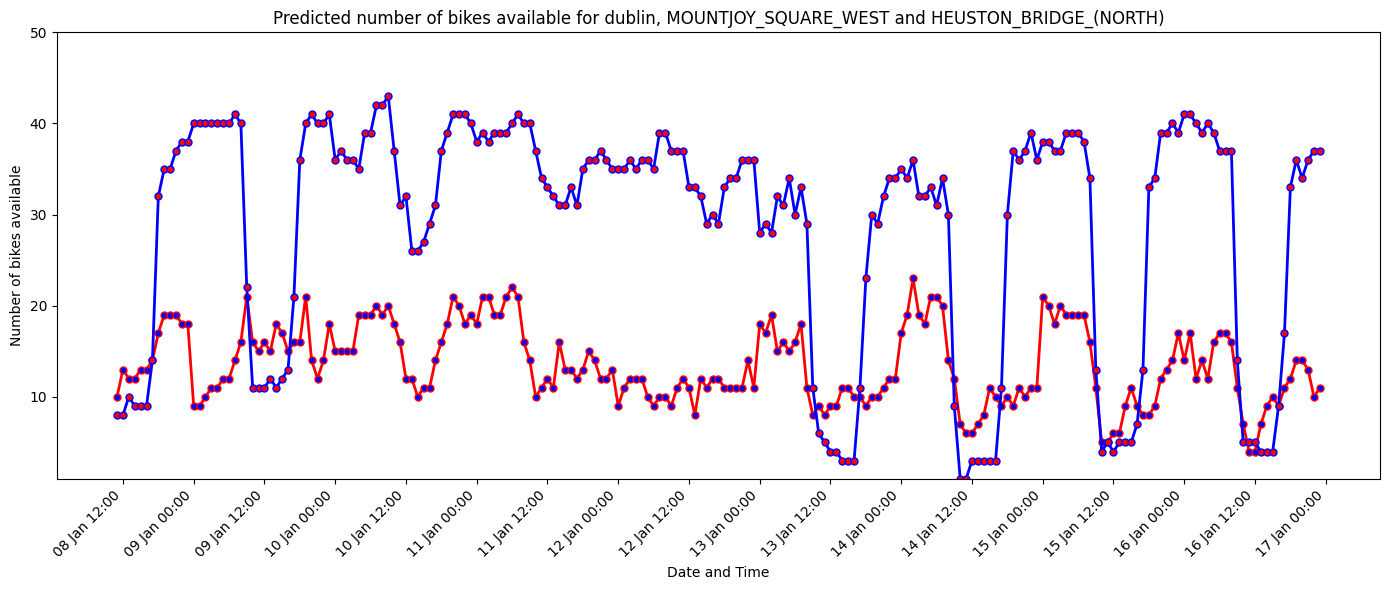

In [13]:
file_path = "docs/bike_availability_forecast.png"
plt = utils.plot_bike_availability_forecast(CITY, STATION_1, STATION_2, batch_data, file_path)
plt.show()

In [14]:
# Get or create feature group
monitor_fg_1 = fs.get_or_create_feature_group(
    name='bike_availability_predictions_stn_1',
    description='Bike availability prediction monitoring for ' + STATION_1.replace("_", " "),
    version=1,
    primary_key=["datetime", "city"],
    event_time="datetime"
)

monitor_fg_2 = fs.get_or_create_feature_group(
    name='bike_availability_predictions_stn_2',
    description='Bike availability prediction monitoring for ' + STATION_2.replace("_", " "),
    version=1,
    primary_key=["datetime", "city"],
    event_time="datetime"
)

In [15]:
monitor_fg_1.insert(batch_data, write_options={"wait_for_job": True})

Uploading Dataframe: 100.00% |██████████| Rows 205/205 | Elapsed Time: 00:01 | Remaining Time: 00:00


Launching job: bike_availability_predictions_1_offline_fg_materialization
Job started successfully, you can follow the progress at 
https://c.app.hopsworks.ai:443/p/1207494/jobs/named/bike_availability_predictions_1_offline_fg_materialization/executions
2025-01-08 09:59:17,388 INFO: Waiting for execution to finish. Current state: SUBMITTED. Final status: UNDEFINED
2025-01-08 09:59:20,567 INFO: Waiting for execution to finish. Current state: RUNNING. Final status: UNDEFINED
2025-01-08 10:01:00,432 INFO: Waiting for execution to finish. Current state: SUCCEEDING. Final status: UNDEFINED
2025-01-08 10:01:10,569 INFO: Waiting for execution to finish. Current state: AGGREGATING_LOGS. Final status: SUCCEEDED
2025-01-08 10:01:10,727 INFO: Waiting for log aggregation to finish.
2025-01-08 10:01:22,651 INFO: Execution finished successfully.


(Job('bike_availability_predictions_1_offline_fg_materialization', 'SPARK'),
 None)

In [16]:
# We will create a hindcast chart for only the forecasts made 1 day beforehand
monitoring_df = monitor_fg.filter(monitor_fg.hours_before_forecast_time >= 24).read()
monitoring_df

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.22s) 


,datetime,temperature_2m,apparent_temperature,rain,snowfall,wind_speed_10m,daylight_duration,rain_sum,city,month,weekday,hour,bikes_available_stn_1,bikes_available_stn_2,hours_before_forecast_time
0,2025-01-09 17:00:00+00:00,-0.25,-4.358046,0.0,0.0,11.901798,28145.916016,0.0,dublin,1,3,17,16,21,31
1,2025-01-13 03:00:00+00:00,11.80,8.508535,0.0,0.0,22.771244,28705.580078,0.0,dublin,1,0,3,15,32,113
2,2025-01-16 03:00:00+00:00,1.85,-0.049115,0.0,0.0,0.360000,29183.220703,0.0,dublin,1,3,3,14,39,185
3,2025-01-13 23:00:00+00:00,10.20,7.092827,0.0,0.0,18.847641,28705.580078,0.0,dublin,1,0,23,12,34,133
4,2025-01-11 05:00:00+00:00,4.50,1.240036,0.0,0.0,11.885453,28413.685547,1.0,dublin,1,5,5,21,39,67
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
177,2025-01-11 21:00:00+00:00,5.00,2.118629,0.0,0.0,11.200571,28413.685547,1.0,dublin,1,5,21,12,37,83
178,2025-01-15 18:00:00+00:00,4.85,3.422315,0.0,0.0,1.018234,29019.097656,0.0,dublin,1,2,18,8,33,176
179,2025-01-12 18:00:00+00:00,11.20,7.584890,0.0,0.0,23.532547,28556.771484,0.9,dublin,1,6,18,11,33,104
180,2025-01-12 13:00:00+00:00,10.05,7.204057,0.1,0.0,17.377226,28556.771484,0.9,dublin,1,6,13,8,33,99


In [21]:
bike_fg = fs.get_feature_group(
    name='bike_data',
    version=1,
)
bike_df = bike_fg.read()

# Split into one for each station
bike_df_1 = bike_df[bike_df["station"] == STATION_1]
bike_df_2 = bike_df[bike_df["station"] == STATION_2]
bike_df_1 = bike_df_1.drop(columns=["station"])
bike_df_2 = bike_df_2.drop(columns=["station"])
bike_df_1

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (2.19s) 


,datetime,num_bikes_available
2,2024-04-09 07:00:00+00:00,8.0
4,2023-12-05 02:00:00+00:00,15.0
5,2024-11-17 14:00:00+00:00,0.0
6,2024-02-16 01:00:00+00:00,14.0
10,2023-11-21 21:00:00+00:00,16.0
...,...,...
18472,2025-01-06 22:49:02+00:00,5.0
18474,2025-01-06 21:49:09+00:00,4.0
18479,2025-01-06 17:49:18+00:00,2.0
18480,2025-01-06 18:49:48+00:00,2.0


In [18]:
weather_fg.read()

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.61s) 


,datetime,temperature_2m,apparent_temperature,rain,snowfall,wind_speed_10m,daylight_duration,rain_sum,city
0,2024-11-17 07:00:00+00:00,6.6395,3.542508,0.0,0.0,13.091829,30647.093750,2.6,dublin
1,2024-07-26 02:00:00+00:00,12.0395,9.959105,0.0,0.0,15.349684,57427.019531,0.9,dublin
2,2024-08-02 09:00:00+00:00,18.9895,18.108223,0.0,0.0,19.469975,56053.718750,2.5,dublin
3,2024-03-28 18:00:00+00:00,8.1395,6.004910,0.1,0.0,4.334974,46005.636719,1.3,dublin
4,2024-01-09 08:00:00+00:00,3.7895,-1.855704,0.0,0.0,21.602999,28177.490234,0.0,dublin
...,...,...,...,...,...,...,...,...,...
12667,2025-01-12 02:00:00+00:00,2.9500,0.515792,0.0,0.0,5.191994,28556.771484,0.9,dublin
12668,2025-01-12 21:00:00+00:00,11.4500,7.875097,0.0,0.0,23.400000,28556.771484,0.9,dublin
12669,2025-01-09 19:00:00+00:00,-2.2500,-6.214783,0.0,0.0,9.531505,28145.916016,0.0,dublin
12670,2025-01-16 13:00:00+00:00,6.7000,5.074124,0.0,0.0,4.693825,29183.220703,0.0,dublin


In [19]:
def backfill_predictions_for_monitoring(weather_fg, air_quality_df, monitor_fg, model):
    features_df = weather_fg.read()

    features_df["month"] = features_df["datetime"].dt.month
    features_df["weekday"] = features_df["datetime"].dt.weekday  # 0=Monday, 6=Sunday
    features_df["hour"] = features_df["datetime"].dt.hour

    features_df = pd.merge(features_df, air_quality_df[['datetime','num_bikes_available']], on="datetime")
    features_df = features_df.sort_values(by=['datetime'], ascending=True)
    features_df = features_df.tail(10)
    
    features_df['bikes_available_stn_1'] = model.predict(features_df[['temperature_2m', 'apparent_temperature', 'rain', 'snowfall', 'wind_speed_10m', 'daylight_duration', 'rain_sum', 'month', 'weekday', 'hour']])
    features_df['bikes_available_stn_1'] = features_df['bikes_available_stn_1'].apply(lambda x: round(x))

    features_df['hours_before_forecast_time'] = range(1, len(features_df) + 1)
    hindcast_df = features_df
    features_df = features_df.drop('num_bikes_available', axis=1)
    monitor_fg.insert(features_df, write_options={"wait_for_job": True})
    return hindcast_df

In [22]:
monitoring_df

,datetime,temperature_2m,apparent_temperature,rain,snowfall,wind_speed_10m,daylight_duration,rain_sum,city,month,weekday,hour,bikes_available_stn_1,bikes_available_stn_2,hours_before_forecast_time
0,2025-01-09 17:00:00+00:00,-0.25,-4.358046,0.0,0.0,11.901798,28145.916016,0.0,dublin,1,3,17,16,21,31
1,2025-01-13 03:00:00+00:00,11.80,8.508535,0.0,0.0,22.771244,28705.580078,0.0,dublin,1,0,3,15,32,113
2,2025-01-16 03:00:00+00:00,1.85,-0.049115,0.0,0.0,0.360000,29183.220703,0.0,dublin,1,3,3,14,39,185
3,2025-01-13 23:00:00+00:00,10.20,7.092827,0.0,0.0,18.847641,28705.580078,0.0,dublin,1,0,23,12,34,133
4,2025-01-11 05:00:00+00:00,4.50,1.240036,0.0,0.0,11.885453,28413.685547,1.0,dublin,1,5,5,21,39,67
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
177,2025-01-11 21:00:00+00:00,5.00,2.118629,0.0,0.0,11.200571,28413.685547,1.0,dublin,1,5,21,12,37,83
178,2025-01-15 18:00:00+00:00,4.85,3.422315,0.0,0.0,1.018234,29019.097656,0.0,dublin,1,2,18,8,33,176
179,2025-01-12 18:00:00+00:00,11.20,7.584890,0.0,0.0,23.532547,28556.771484,0.9,dublin,1,6,18,11,33,104
180,2025-01-12 13:00:00+00:00,10.05,7.204057,0.1,0.0,17.377226,28556.771484,0.9,dublin,1,6,13,8,33,99


In [ ]:
outcome_df_1 = bike_df_1[['datetime', 'num_bikes_available']]
outcome_df_2 = bike_df_2[['datetime', 'num_bikes_available']]

preds_df_1 =  monitoring_df[['datetime', 'bikes_available_stn_1']]
preds_df_1 =  preds_df_1.rename(columns={"bikes_available_stn_1": "predicted_num_bikes_available"})

preds_df_2 =  monitoring_df[['datetime', 'bikes_available_stn_2']]
preds_df_2 =  preds_df_2.rename(columns={"bikes_available_stn_2": "predicted_num_bikes_available"})


hindcast_df_1 = pd.merge(preds_df_1, outcome_df_2, on="datetime")
hindcast_df_1 = hindcast_df_1.sort_values(by=['datetime'])

# print(weather_fg.show(2))
# print(air_quality_fg.show(2))

# If there are no outcomes for predictions yet, generate some predictions/outcomes from existing data
if len(hindcast_df_1) == 0:
    hindcast_df = backfill_predictions_for_monitoring(weather_fg, bike_df_1, monitor_fg, retrieved_xgboost_model_1, retrieved_xgboost_model_2)
hindcast_df

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.69s) 


Uploading Dataframe: 100.00% |██████████| Rows 10/10 | Elapsed Time: 00:01 | Remaining Time: 00:00


Launching job: bike_availability_predictions_1_offline_fg_materialization
Job started successfully, you can follow the progress at 
https://c.app.hopsworks.ai:443/p/1207494/jobs/named/bike_availability_predictions_1_offline_fg_materialization/executions
2025-01-08 10:01:47,127 INFO: Waiting for execution to finish. Current state: SUBMITTED. Final status: UNDEFINED
2025-01-08 10:01:50,314 INFO: Waiting for execution to finish. Current state: RUNNING. Final status: UNDEFINED
2025-01-08 10:03:16,217 INFO: Waiting for execution to finish. Current state: AGGREGATING_LOGS. Final status: SUCCEEDED
2025-01-08 10:03:16,374 INFO: Waiting for log aggregation to finish.
2025-01-08 10:03:38,321 INFO: Execution finished successfully.


,datetime,temperature_2m,apparent_temperature,rain,snowfall,wind_speed_10m,daylight_duration,rain_sum,city,month,weekday,hour,num_bikes_available,bikes_available_stn_1,bikes_available_stn_2,hours_before_forecast_time
1317,2025-01-05 19:00:00+00:00,1.9895,-3.460598,0.7,0.14,24.923338,27805.240234,14.599998,dublin,1,6,19,31.0,25,30,1
1316,2025-01-05 19:00:00+00:00,1.9895,-3.460598,0.7,0.14,24.923338,27805.240234,14.599998,dublin,1,6,19,24.0,25,30,2
5843,2025-01-05 20:00:00+00:00,1.7895,-3.620688,0.5,0.21,24.412407,27805.240234,14.599998,dublin,1,6,20,24.0,23,30,3
5842,2025-01-05 20:00:00+00:00,1.7895,-3.620688,0.5,0.21,24.412407,27805.240234,14.599998,dublin,1,6,20,31.0,23,30,4
773,2025-01-05 21:00:00+00:00,1.6895,-3.813852,0.4,0.28,24.933735,27805.240234,14.599998,dublin,1,6,21,24.0,24,31,5
772,2025-01-05 21:00:00+00:00,1.6895,-3.813852,0.4,0.28,24.933735,27805.240234,14.599998,dublin,1,6,21,31.0,24,31,6
6775,2025-01-05 22:00:00+00:00,1.9395,-3.524250,0.5,0.14,24.662626,27805.240234,14.599998,dublin,1,6,22,31.0,23,31,7
6774,2025-01-05 22:00:00+00:00,1.9395,-3.524250,0.5,0.14,24.662626,27805.240234,14.599998,dublin,1,6,22,24.0,23,31,8
10257,2025-01-05 23:00:00+00:00,1.9895,-3.496983,0.5,0.00,24.702005,27805.240234,14.599998,dublin,1,6,23,24.0,24,31,9
10256,2025-01-05 23:00:00+00:00,1.9895,-3.496983,0.5,0.00,24.702005,27805.240234,14.599998,dublin,1,6,23,31.0,24,31,10
